In [ ]:
import onnxruntime as ort
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# Load the ONNX model
model_path = "/content/DenseNet121.onnx"
session = ort.InferenceSession(model_path, providers=["CPUExecutionProvider"])

# Preprocess the frame
def preprocess_frame(frame, input_size=(128, 128)):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, input_size)
    frame = frame.astype(np.float32) / 255.0  # Normalize to [0,1]

    # Ensure correct input shape (batch_size, height, width, channels)
    frame = np.expand_dims(frame, axis=0)

    return frame

# Perform inference on a single frame
def predict(frame):
    image = preprocess_frame(frame)

    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name

    outputs = session.run([output_name], {input_name: image})

    # Extract probability
    prob = outputs[0][0][0]  # Assuming model outputs probability of "No Fire"

    # Convert to Fire probability (1 - prob)
    fire_prob = 1 - prob

    return fire_prob

# Apply fire detection per area independently
def detect_fire_areas(frame, min_box_size=500):
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower_red1 = np.array([0, 50, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 50, 50])
    upper_red2 = np.array([180, 255, 255])

    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = mask1 + mask2

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours by size
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_box_size]

    return filtered_contours, mask

# Process video
def process_video(video_path, output_path="output.mp4", display_frames=True, min_box_size=500):
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the video writer
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Stop when video ends

        # Detect potential fire areas (only keep large enough ones)
        fire_contours, fire_mask = detect_fire_areas(frame, min_box_size)

        # Draw fire probability text in the top-right corner
        fire_prob = predict(frame)  # Overall frame fire probability
        text = f"Fire Probability: {fire_prob:.2f}"
        text_color = (0, 0, 255) if fire_prob > 0.5 else (0, 255, 0)  # Red if fire is likely

        # Get text size for proper alignment
        font_scale = 0.8
        thickness = 2
        font = cv2.FONT_HERSHEY_SIMPLEX
        text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]

        text_x = width - text_size[0] - 20  # Right-aligned
        text_y = 50  # Position from top

        cv2.putText(frame, text, (text_x, text_y), font, font_scale, text_color, thickness)

        # Process each detected fire region independently
        for contour in fire_contours:
            x, y, w, h = cv2.boundingRect(contour)

            # Extract region from fire mask to estimate fire intensity
            fire_region = fire_mask[y:y+h, x:x+w]
            fire_intensity = np.mean(fire_region) / 255.0  # Normalize between 0-1

            box_color = (0, 255, 0) if fire_intensity > 0.5 else (0, 0, 255)

            # Draw the bounding box
            cv2.rectangle(frame, (x, y), (x + w, y + h), box_color, 2)

        # Write the processed frame to output video
        out.write(frame)

        # Display frames in Colab every 20 frames
        if display_frames and frame_count % 20 == 0:
            cv2_imshow(frame)

        frame_count += 1

    # Cleanup
    cap.release()
    out.release()

    print(f"Processed video saved as {output_path}")

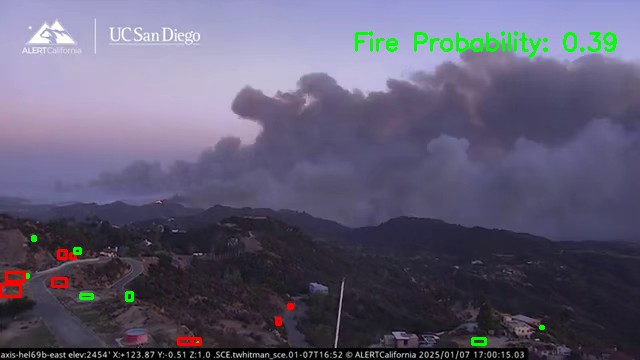

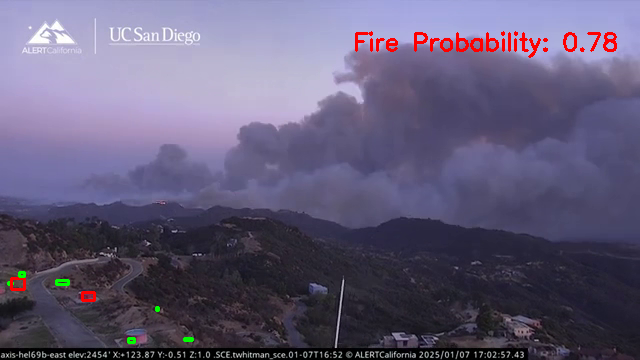

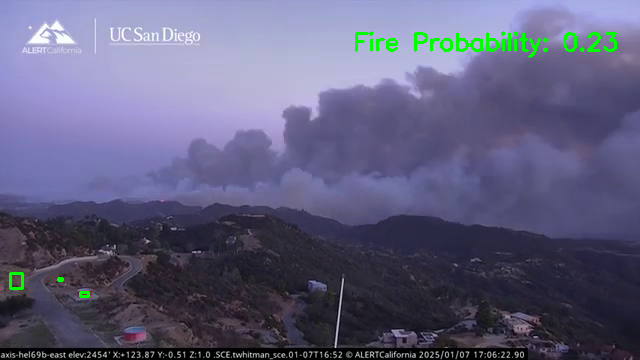

KeyboardInterrupt: 

In [ ]:
# Example usage (set min_box_size as needed)
video_path = "/content/input.mp4"  # Change this to your video path
process_video(video_path, min_box_size=1)  # Adjust this value to filter small boxes